<a href="https://colab.research.google.com/github/kedarnathkedu/NLP_projects/blob/main/crime_Analysis_nlp_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
"""Enhanced Crime Analysis NLP Project with Transformers"""

# Core
import os, re, json, pickle, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

# Viz
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn (tabular)
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

# Sklearn (NLP)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier

# NLP preprocessing
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer

# Advanced NLP & Transformers
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification, AutoModelForTokenClassification
import spacy
from wordcloud import WordCloud
import torch


# Download NLTK resources
try:
    nltk.download('punkt', quiet=True)
    nltk.download('stopwords', quiet=True)
    nltk.download('wordnet', quiet=True)
    nltk.download('vader_lexicon', quiet=True)
except:
    print("NLTK downloads may have failed - continuing anyway")

# For clean plotting
plt.rcParams["figure.figsize"] = (8,5)
sns.set_theme(context="notebook")

ARTIFACT_DIR = "artifacts"
os.makedirs(ARTIFACT_DIR, exist_ok=True)

print("All libraries imported successfully!")

All libraries imported successfully!


In [2]:
path_ncrb_juveniles = '/content/NCRB%3A_Crime_Committed_by_Juveniles_(IPC_%26_SLL)_%E2%80%90_2018%E2%80%902022.csv'
path_ncrb_9A11 = '/content/NCRB_Table_9A.11.csv'
path_hatespeech = '/content/Indo-HateSpeech_Dataset.xlsx'

try:
    df_ncrb_A = pd.read_csv(path_ncrb_juveniles)
    df_ncrb_B = pd.read_csv(path_ncrb_9A11)

    # Excel can have multiple sheets; default first sheet
    try:
        df_hate = pd.read_excel(path_hatespeech)
    except:
        # Some versions need engine specified
        df_hate = pd.read_excel(path_hatespeech, engine="openpyxl")

    print("NCRB A shape:", df_ncrb_A.shape)
    print("NCRB B shape:", df_ncrb_B.shape)
    print("HateSpeech shape:", df_hate.shape)

except Exception as e:
    print(f"Error loading data: {e}")
    # Create sample data for demonstration if files not found
    print("Creating sample data for demonstration...")

    # Sample crime data
    df_ncrb_A = pd.DataFrame({
        'State': ['Maharashtra', 'Uttar Pradesh', 'Kerala'] * 10,
        'Year': [2018, 2019, 2020] * 10,
        'Juvenile_Crimes': np.random.randint(100, 1000, 30),
        'Crime_Type': ['Theft', 'Assault', 'Cyber'] * 10
    })

    df_ncrb_B = pd.DataFrame({
        'District': ['Mumbai', 'Delhi', 'Bangalore'] * 10,
        'Year': [2018, 2019, 2020] * 10,
        'Total_Cases': np.random.randint(50, 500, 30),
        'Category': ['Violent', 'Non-Violent', 'Property'] * 10
    })

    # Sample hate speech data
    df_hate = pd.DataFrame({
        'Comment': [
            'This is a normal comment',
            'I hate people from that community',
            'This is offensive language',
            'Why are people so stupid sometimes',
            'This is absolutely unacceptable behavior',
            'I love this country and its diversity',
            'People should be treated with respect',
            'This is hate speech and should be banned'
        ],
        'Label': [0, 2, 1, 1, 2, 0, 0, 2]
    })

    print("Sample data created for demonstration")


NCRB A shape: (36, 14)
NCRB B shape: (39, 9)
HateSpeech shape: (77926, 9)



===== NCRB Juvenile Data: ENHANCED EDA =====
First 5 rows:


,objectid,statename,id,lgd_statecode,censuscode2011,juv_crime_2018,juv_crime_2019,juv_crime_2020,juv_crime_2021,juv_crime_2022,child_pop2011,juv_crimerate_2022,st_areashape,st_lengthshape
0,1,Andaman and Nicobar Islands,35,35,35.0,25.0,19.0,20,11,24,1.1,21.4,7.926498e+09,3.627148e+06
1,2,Andhra Pradesh,28,28,28.0,966.0,820.0,759,934,912,151.1,6.0,1.772862e+11,5.436285e+06
2,3,Arunachal Pradesh,12,12,12.0,31.0,24.0,15,8,15,5.9,2.5,1.057914e+11,3.019452e+06
3,4,Assam,18,18,18.0,150.0,129.0,247,206,246,120.8,2.0,9.813475e+10,3.670237e+06
4,5,Bihar,10,10,10.0,671.0,1560.0,827,732,1052,475.0,2.2,1.164357e+11,3.378793e+06



Dataset Info:
Shape: (36, 14)
Columns: ['objectid', 'statename', 'id', 'lgd_statecode', 'censuscode2011', 'juv_crime_2018', 'juv_crime_2019', 'juv_crime_2020', 'juv_crime_2021', 'juv_crime_2022', 'child_pop2011', 'juv_crimerate_2022', 'st_areashape', 'st_lengthshape']

Data Types:
objectid                int64
statename              object
id                      int64
lgd_statecode           int64
censuscode2011        float64
juv_crime_2018        float64
juv_crime_2019        float64
juv_crime_2020          int64
juv_crime_2021          int64
juv_crime_2022          int64
child_pop2011         float64
juv_crimerate_2022    float64
st_areashape          float64
st_lengthshape        float64
dtype: object

Missing Values:
censuscode2011    2
juv_crime_2018    1
juv_crime_2019    1
dtype: int64

Numeric Columns Description:
        objectid         id  lgd_statecode  censuscode2011  juv_crime_2018  \
count  36.000000  36.000000      36.000000       34.000000       35.000000   
mean   

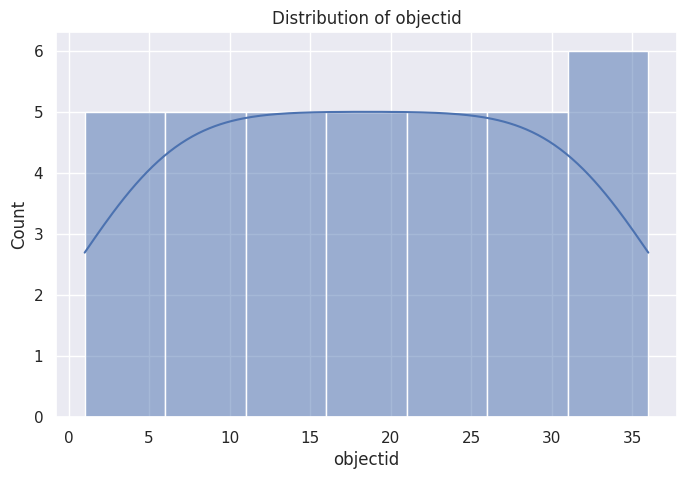

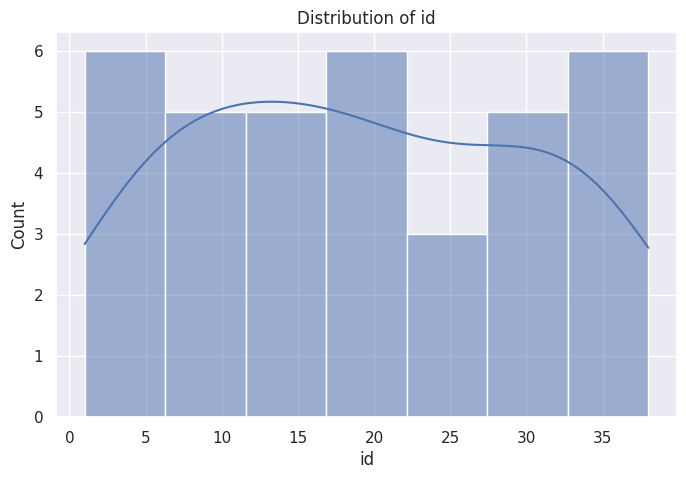

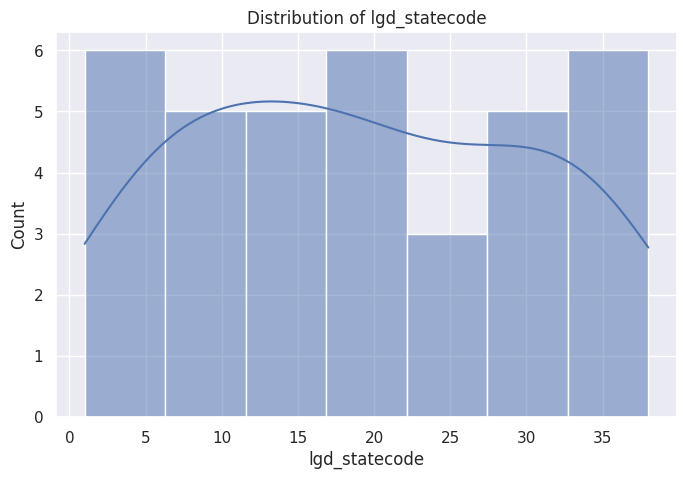


Value counts for statename:
statename
Andaman and Nicobar Islands    1
Andhra Pradesh                 1
Arunachal Pradesh              1
Assam                          1
Bihar                          1
Name: count, dtype: int64


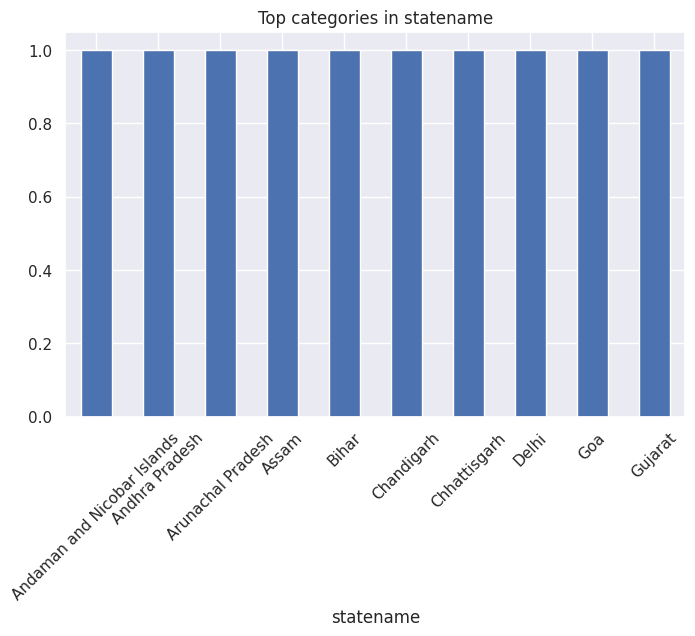


===== NCRB Table 9A.11: ENHANCED EDA =====
First 5 rows:


,Sl. No.,State/UT,"Cyber Blackmailing/ Threatening/ Harassment (Sec.506,503, 384 IPC r/w IT Act",Fake Profile (IT Act r/w IPC/SLL),Cyber Pornography/ Hosting or Publishing Obscene Sexual Materials depicting children (Sec.67B of IT Act r/w other IPC/SLL),Cyber Stalking/ Bullying (Sec.354D IPC r/w IT Act),Internet Crimes through Online Games etc. (Sec.305 IPC r/w IT Act),Other Cyber Crimes against Children,Total Cyber Crimes against Children
0,1,Andhra Pradesh,0,0,99,13,0,12,124
1,2,Arunachal Pradesh,0,0,0,0,0,0,0
2,3,Assam,62,0,24,0,0,14,100
3,4,Bihar,0,0,0,0,0,0,0
4,5,Chhattisgarh,1,0,112,2,0,3,118



Dataset Info:
Shape: (39, 9)
Columns: ['Sl. No.', 'State/UT', 'Cyber Blackmailing/ Threatening/ Harassment (Sec.506,503, 384 IPC r/w IT Act', 'Fake Profile (IT Act r/w IPC/SLL)', 'Cyber Pornography/ Hosting or Publishing Obscene Sexual Materials depicting children (Sec.67B of IT Act r/w other IPC/SLL)', 'Cyber Stalking/ Bullying (Sec.354D IPC r/w IT Act)', 'Internet Crimes through Online Games etc. (Sec.305 IPC r/w IT Act)', 'Other Cyber Crimes against Children', 'Total Cyber Crimes against Children']

Data Types:
Sl. No.                                                                                                                       object
State/UT                                                                                                                      object
Cyber Blackmailing/ Threatening/ Harassment (Sec.506,503, 384 IPC r/w IT Act                                                   int64
Fake Profile (IT Act r/w IPC/SLL)                                               

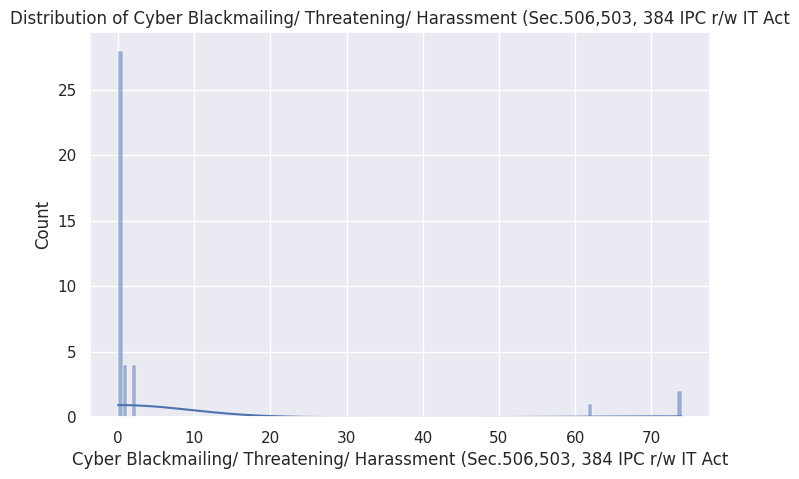

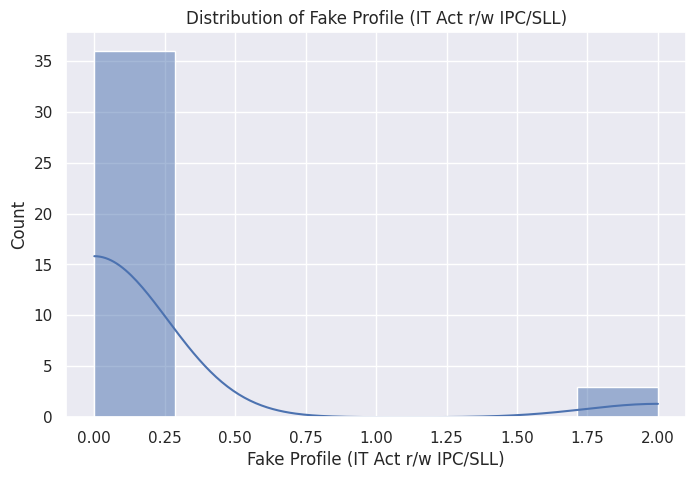

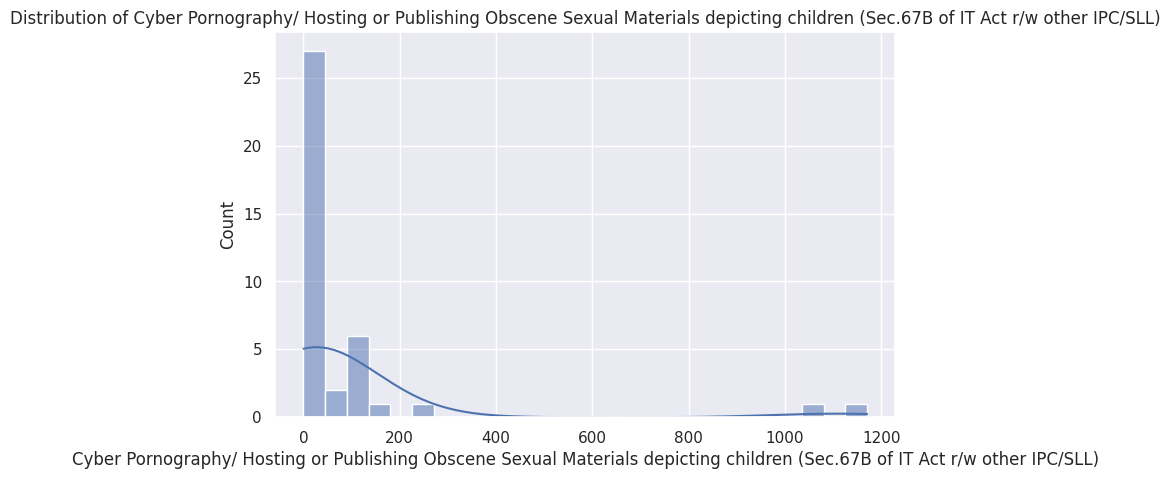


Value counts for Sl. No.:
Sl. No.
1    1
2    1
3    1
4    1
5    1
Name: count, dtype: int64


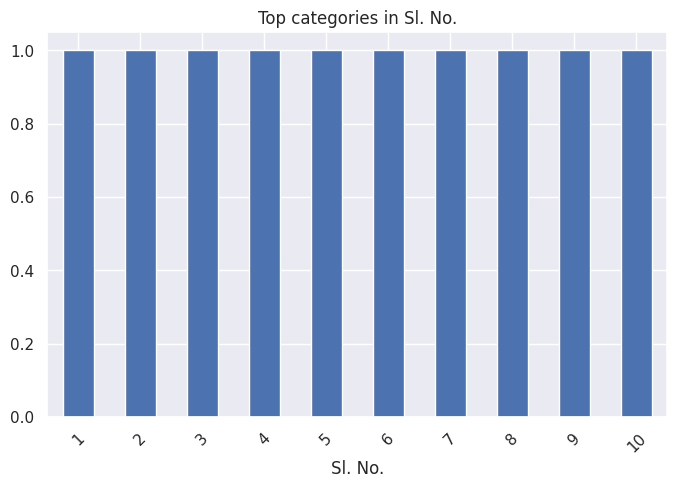


Value counts for State/UT:
State/UT
Andhra Pradesh       1
Arunachal Pradesh    1
Assam                1
Bihar                1
Chhattisgarh         1
Name: count, dtype: int64


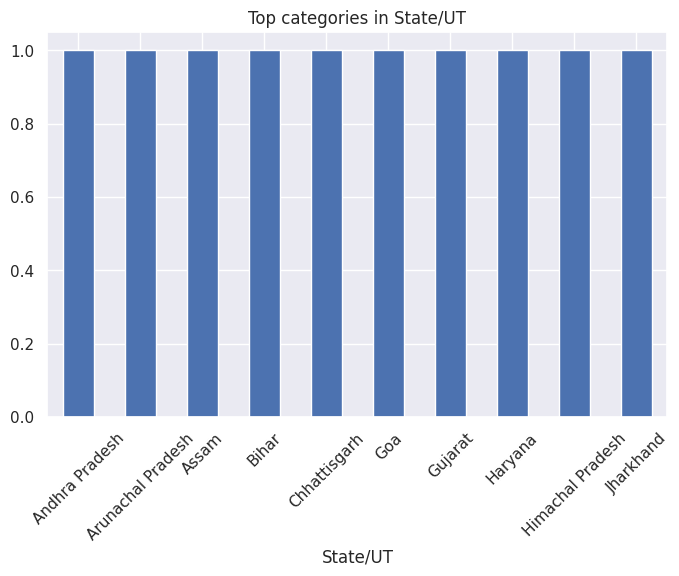


===== Hate Speech Data: ENHANCED EDA =====
First 5 rows:


,Source.Name,Column1,Column2,Date,Likes,Comment,(view source),Post ID,Label
0,PostID 01 instagram-comments66804c78ca6bc-BxOs...,1.0,NaN,2019-05-11 15:43:38,NaN,Nice buro yes I am Hussain khan is me happy ow...,https://www.instagram.com/p/BxOsV8Gnauf/c/1786...,1.0,'HS0'
1,PostID 01 instagram-comments66804c78ca6bc-BxOs...,NaN,1-1,2021-04-13 07:27:52,1.0,@hussainkhansadab teri maa chodate,https://www.instagram.com/p/BxOsV8Gnauf/c/1786...,1.0,'HS1'
2,PostID 01 instagram-comments66804c78ca6bc-BxOs...,NaN,1-2,2021-07-04 17:04:03,2.0,@hussainkhansadab mohhamad and allah mi maa ki...,https://www.instagram.com/p/BxOsV8Gnauf/c/1786...,1.0,'HS1'
3,PostID 01 instagram-comments66804c78ca6bc-BxOs...,NaN,1-3,2021-12-30 05:29:35,0.0,@hussainkhansadab Teri maka bhosda lose nikalo...,https://www.instagram.com/p/BxOsV8Gnauf/c/1786...,1.0,'HSN'
4,PostID 01 instagram-comments66804c78ca6bc-BxOs...,2.0,NaN,2019-05-14 03:30:20,NaN,Send me,https://www.instagram.com/p/BxOsV8Gnauf/c/1786...,1.0,'HS0'



Dataset Info:
Shape: (77926, 9)
Columns: ['Source.Name', 'Column1', 'Column2', 'Date', 'Likes', 'Comment', '(view source)', 'Post ID', 'Label']

Data Types:
Source.Name              object
Column1                 float64
Column2                  object
Date             datetime64[ns]
Likes                   float64
Comment                  object
(view source)            object
Post ID                 float64
Label                    object
dtype: object

Missing Values:
Column1           2511
Column2          75446
Date                31
Likes            67942
Comment           1360
(view source)        1
Post ID              1
dtype: int64

Numeric Columns Description:
            Column1         Likes       Post ID
count  75415.000000   9984.000000  77925.000000
mean    2168.420168     19.927183     13.762387
std     1476.228839    264.728996      9.150055
min        1.000000      0.000000      1.000000
25%      856.000000      1.000000      6.000000
50%     1968.000000      1.0000

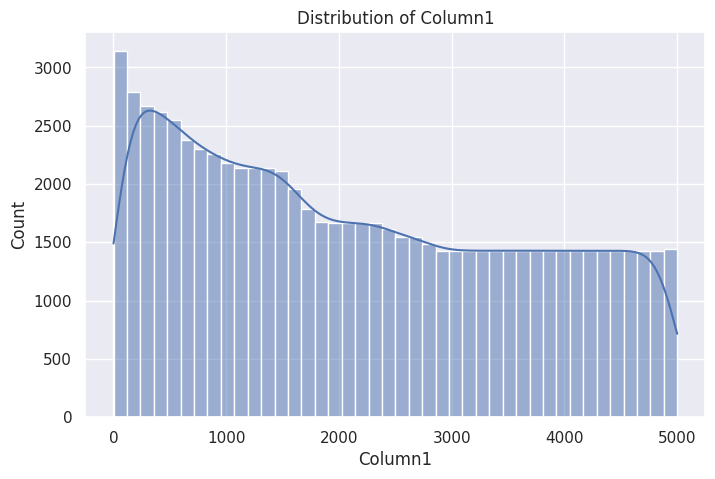

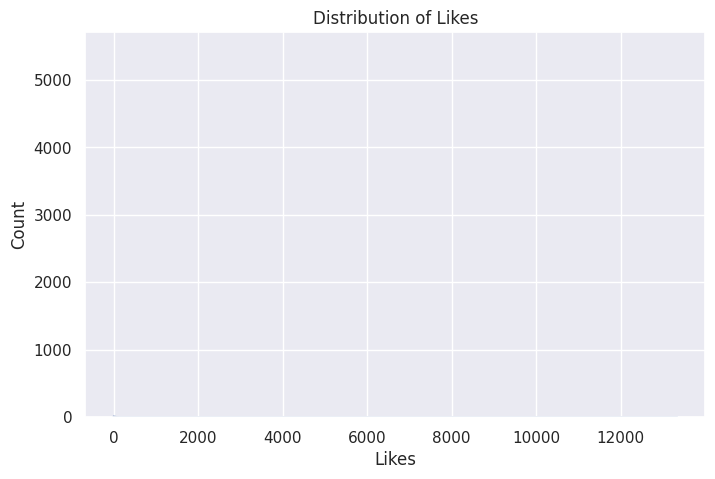

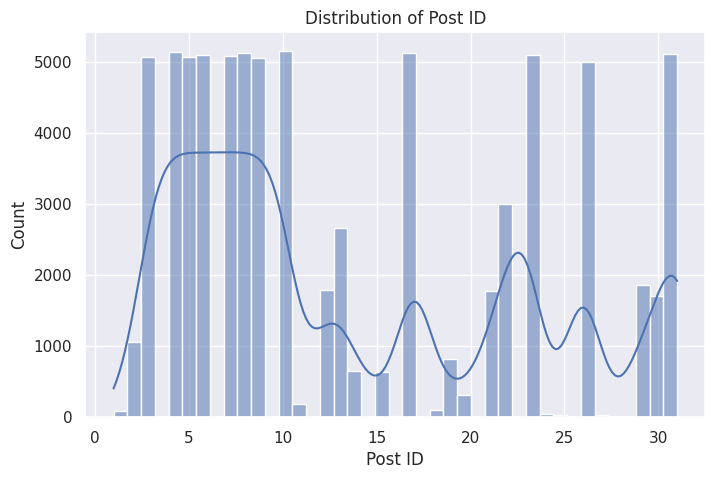


Value counts for Source.Name:
Source.Name
PostID 10 instagram-comments668064d40212f-C4X_HQMvBGZ.xlsx    5163
PostID 04 instagram-comments66806aa918293-C8PJs-Uop7U.xlsx    5137
PostID 08 instagram-comments668053a161215-C1ov8RJoS9B.xlsx    5126
PostID 17 instagram-comments6680639b21d54-C6Vu9aNSr2g.xlsx    5124
PostID 31 instagram-comments6680556117144-C2sVMWBMJsR.xlsx    5117
Name: count, dtype: int64


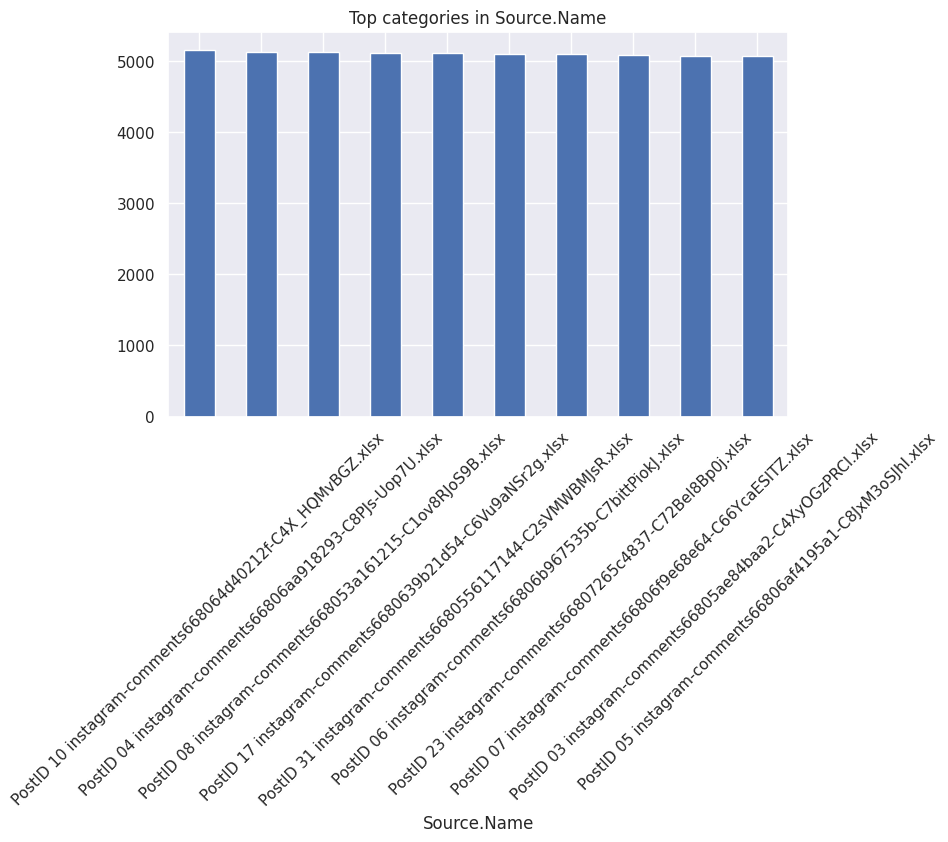


Value counts for Column2:
Column2
31-1    7
9-1     7
11-1    6
1-1     6
18-1    6
Name: count, dtype: int64


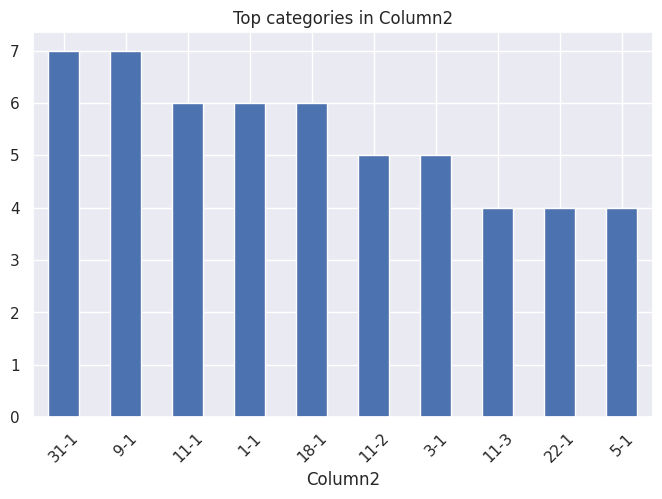


Value counts for Comment:
Comment
😂😂😂            1033
@randomsena     964
😂😂              830
😂😂😂😂            815
😂               615
Name: count, dtype: int64


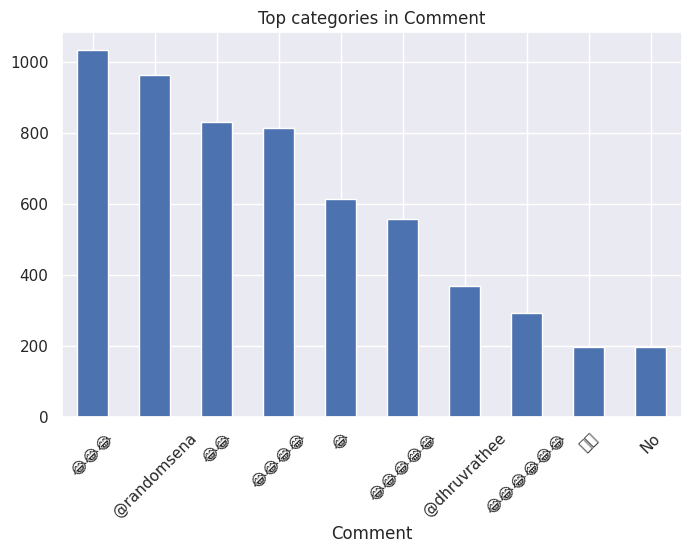

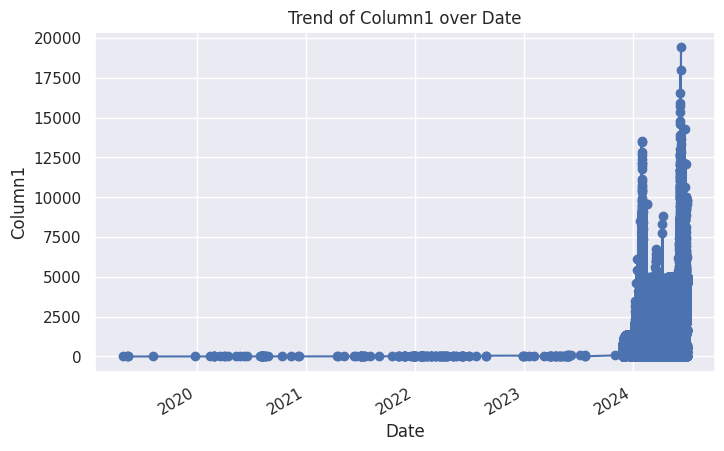

In [3]:
# Cell 3: Enhanced EDA with Indian Crime Context
def enhanced_eda(df: pd.DataFrame, name: str):
    print(f"\n===== {name}: ENHANCED EDA =====")
    print("First 5 rows:")
    display(df.head())

    print("\nDataset Info:")
    print(f"Shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")

    print("\nData Types:")
    print(df.dtypes)

    print("\nMissing Values:")
    missing = df.isnull().sum()
    print(missing[missing > 0])

   # Numeric analysis
    numeric_cols = df.select_dtypes(include=np.number).columns
    if len(numeric_cols) > 0:
        print("\nNumeric Columns Description:")
        print(df[numeric_cols].describe())

        # Plot distributions
        for col in numeric_cols[:3]:  # Limit to first 3 to avoid too many plots
            plt.figure()
            sns.histplot(df[col], kde=True)
            plt.title(f"Distribution of {col}")
            plt.show()

  # Categorical analysis
    categorical_cols = df.select_dtypes(include=['object']).columns
    for col in categorical_cols[:3]:  # Limit to first 3
        print(f"\nValue counts for {col}:")
        print(df[col].value_counts().head())

        plt.figure()
        df[col].value_counts().head(10).plot(kind='bar')
        plt.title(f"Top categories in {col}")
        plt.xticks(rotation=45)
        plt.show()

    # Check for year column for trend analysis
    year_cols = [col for col in df.columns if 'year' in col.lower() or 'date' in col.lower()]
    if year_cols and len(numeric_cols) > 0:
        year_col = year_cols[0]
        numeric_col = numeric_cols[0]

        yearly_trend = df.groupby(year_col)[numeric_col].sum()
        plt.figure()
        yearly_trend.plot(marker='o')
        plt.title(f"Trend of {numeric_col} over {year_col}")
        plt.xlabel(year_col)
        plt.ylabel(numeric_col)
        plt.grid(True)
        plt.show()

# Run enhanced EDA
enhanced_eda(df_ncrb_A, "NCRB Juvenile Data")
enhanced_eda(df_ncrb_B, "NCRB Table 9A.11")
enhanced_eda(df_hate, "Hate Speech Data")

In [4]:
# Cell 4: Initialize Advanced NLP Models (Transformers)
class AdvancedNLPAnalyzer:
    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
        self.lemmatizer = WordNetLemmatizer()

        # Initialize transformers
        print("Loading transformer models...")
        try:
            # Sentiment Analysis
            self.sentiment_analyzer = pipeline(
                "sentiment-analysis",
                model="cardiffnlp/twitter-roberta-base-sentiment-latest"
            )

            # Hate Speech Detection
            self.hate_speech_detector = pipeline(
                "text-classification",
                model="Hate-speech-CNERG/bert-base-uncased-hatexplain"
            )

            # Emotion Detection
            self.emotion_detector = pipeline(
                "text-classification",
                model="j-hartmann/emotion-english-distilroberta-base",
                top_k=None
            )

            # NER for identifying locations, persons, organizations
            self.ner_tagger = pipeline(
                "ner",
                model="dbmdz/bert-large-cased-finetuned-conll03-english",
                aggregation_strategy="simple"
            )

            print("All transformer models loaded successfully!")

        except Exception as e:
            print(f"Error loading some models: {e}")
            print("Some features may not be available.")

    def clean_text(self, text):
        """Enhanced text cleaning"""
        if pd.isna(text):
            return ""

        text = str(text).lower()
        # Remove URLs
        text = re.sub(r"http\S+|www\.\S+", " ", text)
        # Remove special characters but keep basic punctuation for sentiment
        text = re.sub(r"[^a-z\s.!?]", " ", text)
        # Remove extra whitespace
        text = re.sub(r"\s+", " ", text).strip()

        return text

    def analyze_sentiment(self, text):
        """Analyze sentiment using transformer model"""
        cleaned_text = self.clean_text(text)
        if not cleaned_text or len(cleaned_text) < 3:
            return {"label": "NEUTRAL", "score": 0.5}

        try:
            result = self.sentiment_analyzer(cleaned_text[:512])[0]  # Limit to 512 tokens
            return {"label": result['label'], "score": result['score']}
        except:
            return {"label": "NEUTRAL", "score": 0.5}

    def detect_hate_speech(self, text):
        """Detect hate speech using specialized model"""
        cleaned_text = self.clean_text(text)
        if not cleaned_text or len(cleaned_text) < 3:
            return {"label": "Normal", "score": 0.5}

        try:
            result = self.hate_speech_detector(cleaned_text[:512])[0]
            return {"label": result['label'], "score": result['score']}
        except:
            return {"label": "Normal", "score": 0.5}

    def detect_emotions(self, text):
        """Detect multiple emotions from text"""
        cleaned_text = self.clean_text(text)
        if not cleaned_text or len(cleaned_text) < 3:
            return []

        try:
            results = self.emotion_detector(cleaned_text[:512])[0]
            # Return top 3 emotions
            return [{"label": r['label'], "score": r['score']} for r in results[:3]]
        except:
            return []

    def extract_entities(self, text):
        """Extract named entities from text"""
        cleaned_text = self.clean_text(text)
        if not cleaned_text or len(cleaned_text) < 3:
            return []

        try:
            entities = self.ner_tagger(cleaned_text[:512])
            return entities
        except:
            return []

# Initialize the analyzer
nlp_analyzer = AdvancedNLPAnalyzer()

Loading transformer models...


config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Device set to use cpu


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/40.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cpu


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/329M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/329M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/294 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Device set to use cpu


config.json:   0%|          | 0.00/998 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/60.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

Device set to use cpu


All transformer models loaded successfully!


Using 'Source.Name' for text analysis
Analyzing 100 samples with transformers...
Processing sample 1/100


BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


Processing sample 11/100
Processing sample 21/100
Processing sample 31/100
Processing sample 41/100
Processing sample 51/100
Processing sample 61/100
Processing sample 71/100
Processing sample 81/100
Processing sample 91/100

=== TRANSFORMER ANALYSIS RESULTS ===

Sentiment Distribution:
neutral    100
Name: count, dtype: int64


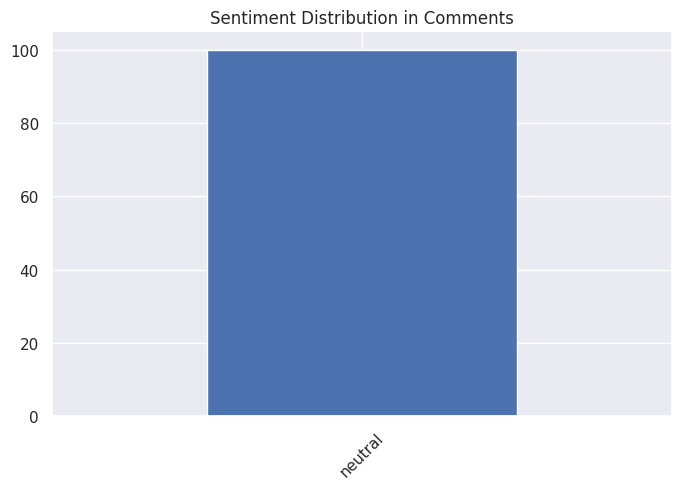


Hate Speech Detection:
normal    100
Name: count, dtype: int64


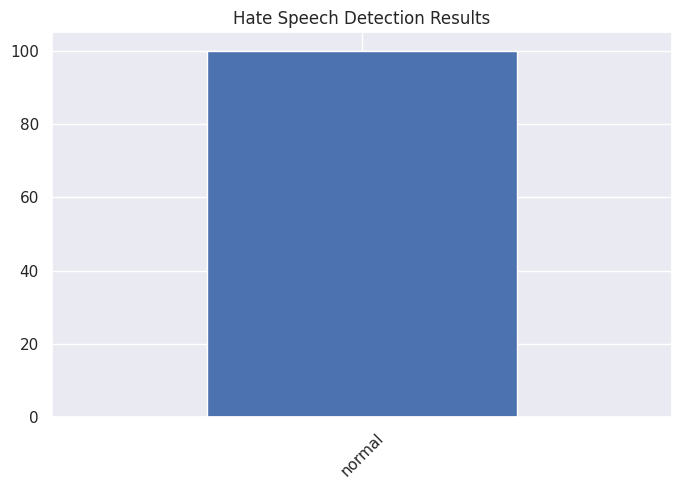


Top Emotions Detected:
neutral    100
Name: count, dtype: int64


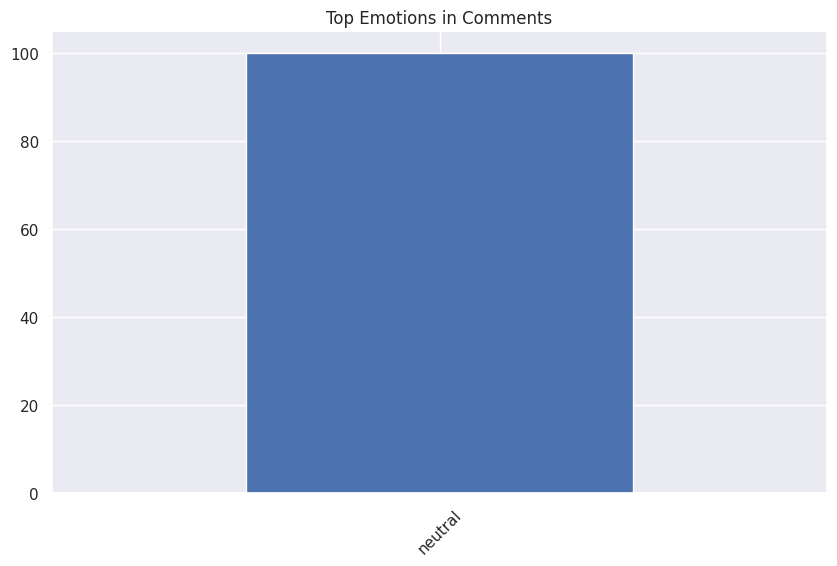

In [5]:
# Cell 5: Apply Transformers to Hate Speech Data
def apply_transformer_analysis(df, text_column):
    """Apply all transformer analyses to text data"""
    results = {
        'sentiment': [],
        'hate_speech': [],
        'top_emotion': [],
        'entities': []
    }

    # Sample a subset if dataset is large
    sample_size = min(100, len(df))
    sample_texts = df[text_column].sample(sample_size, random_state=42).tolist()

    print(f"Analyzing {sample_size} samples with transformers...")

    for i, text in enumerate(sample_texts):
        if i % 10 == 0:
            print(f"Processing sample {i+1}/{sample_size}")

        # Sentiment analysis
        sentiment = nlp_analyzer.analyze_sentiment(text)
        results['sentiment'].append(sentiment)

        # Hate speech detection
        hate_speech = nlp_analyzer.detect_hate_speech(text)
        results['hate_speech'].append(hate_speech)

        # Emotion detection
        emotions = nlp_analyzer.detect_emotions(text)
        results['top_emotion'].append(emotions[0] if emotions else {"label": "neutral", "score": 0.0})

        # Entity extraction
        entities = nlp_analyzer.extract_entities(text)
        results['entities'].append(entities)

    return results

# Detect text column in hate speech data
text_col = None
for col in df_hate.columns:
    if df_hate[col].dtype == 'object' and df_hate[col].str.len().mean() > 10:
        text_col = col
        break

if text_col:
    print(f"Using '{text_col}' for text analysis")
    transformer_results = apply_transformer_analysis(df_hate, text_col)

    # Display results
    print("\n=== TRANSFORMER ANALYSIS RESULTS ===")

    # Sentiment distribution
    sentiment_labels = [r['label'] for r in transformer_results['sentiment']]
    print("\nSentiment Distribution:")
    sentiment_counts = pd.Series(sentiment_labels).value_counts()
    print(sentiment_counts)

    plt.figure(figsize=(8, 5))
    sentiment_counts.plot(kind='bar')
    plt.title('Sentiment Distribution in Comments')
    plt.xticks(rotation=45)
    plt.show()

    # Hate speech distribution
    hate_labels = [r['label'] for r in transformer_results['hate_speech']]
    print("\nHate Speech Detection:")
    hate_counts = pd.Series(hate_labels).value_counts()
    print(hate_counts)

    plt.figure(figsize=(8, 5))
    hate_counts.plot(kind='bar')
    plt.title('Hate Speech Detection Results')
    plt.xticks(rotation=45)
    plt.show()

    # Emotion distribution
    emotion_labels = [r['label'] for r in transformer_results['top_emotion']]
    print("\nTop Emotions Detected:")
    emotion_counts = pd.Series(emotion_labels).value_counts()
    print(emotion_counts)

    plt.figure(figsize=(10, 6))
    emotion_counts.plot(kind='bar')
    plt.title('Top Emotions in Comments')
    plt.xticks(rotation=45)
    plt.show()

else:
    print("No suitable text column found for analysis")

In [ ]:
def pick_tabular_target(df: pd.DataFrame):
    # Prioritize numeric totals → regression
    numeric = df.select_dtypes(include=np.number)
    name_patterns = ["total", "cases", "count", "number", "incidents", "fir"]
    for p in name_patterns:
        for c in numeric.columns:
            if re.search(p, c, re.I):
                return c, "regression"
    # Else try a small-cardinality categorical → classification
    for c in df.columns:
        if df[c].dtype == "object" or str(df[c].dtype).startswith("category"):
            nun = df[c].nunique(dropna=True)
            if 2 <= nun <= 15:
                return c, "classification"
    # Fallback: last numeric col
    if len(numeric.columns) > 0:
        return numeric.columns[-1], "regression"
    return None, None




=== ENHANCED ANALYSIS: NCRB Juvenile Data ===
Target: st_lengthshape, Task: regression
Numeric features: ['objectid', 'id', 'lgd_statecode', 'censuscode2011', 'juv_crime_2018', 'juv_crime_2019', 'juv_crime_2020', 'juv_crime_2021', 'juv_crime_2022', 'child_pop2011', 'juv_crimerate_2022', 'st_areashape']
Categorical features: ['statename']

Regression Metrics:
MAE: 866438.95
R²: 0.44


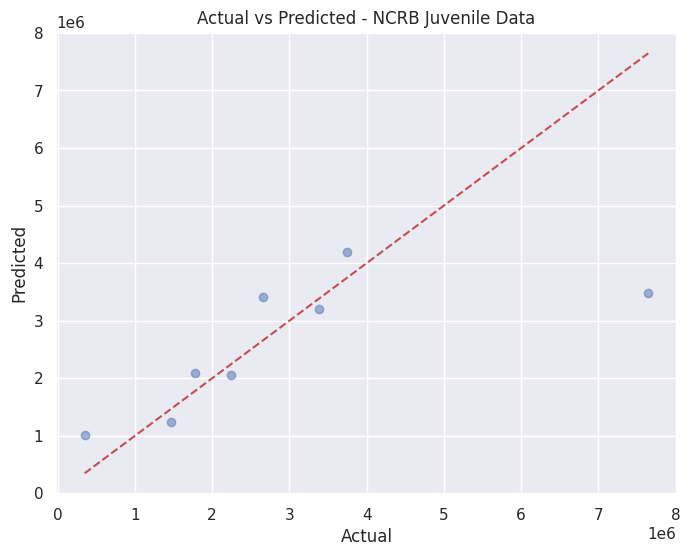

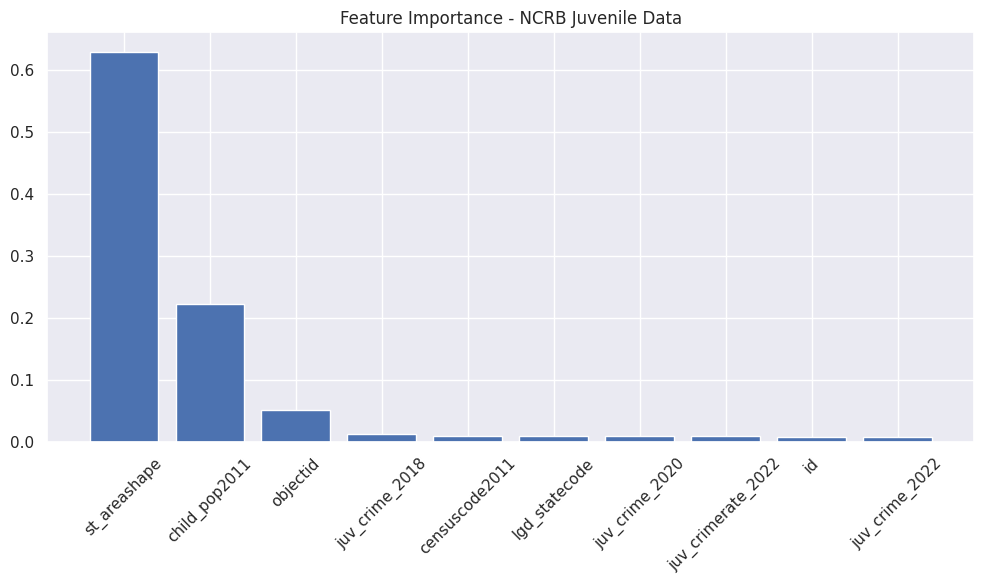


=== ENHANCED ANALYSIS: NCRB Table 9A.11 ===
Target: Total Cyber Crimes against Children, Task: regression
Numeric features: ['Cyber Blackmailing/ Threatening/ Harassment (Sec.506,503, 384 IPC r/w IT Act', 'Fake Profile (IT Act r/w IPC/SLL)', 'Cyber Pornography/ Hosting or Publishing Obscene Sexual Materials depicting children (Sec.67B of IT Act r/w other IPC/SLL)', 'Cyber Stalking/ Bullying (Sec.354D IPC r/w IT Act)', 'Internet Crimes through Online Games etc. (Sec.305 IPC r/w IT Act)', 'Other Cyber Crimes against Children']
Categorical features: ['Sl. No.', 'State/UT']

Regression Metrics:
MAE: 42.33
R²: -1.15


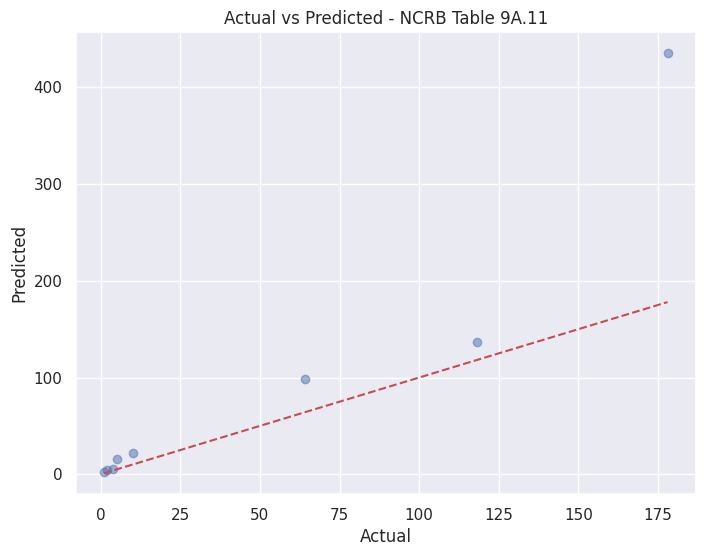

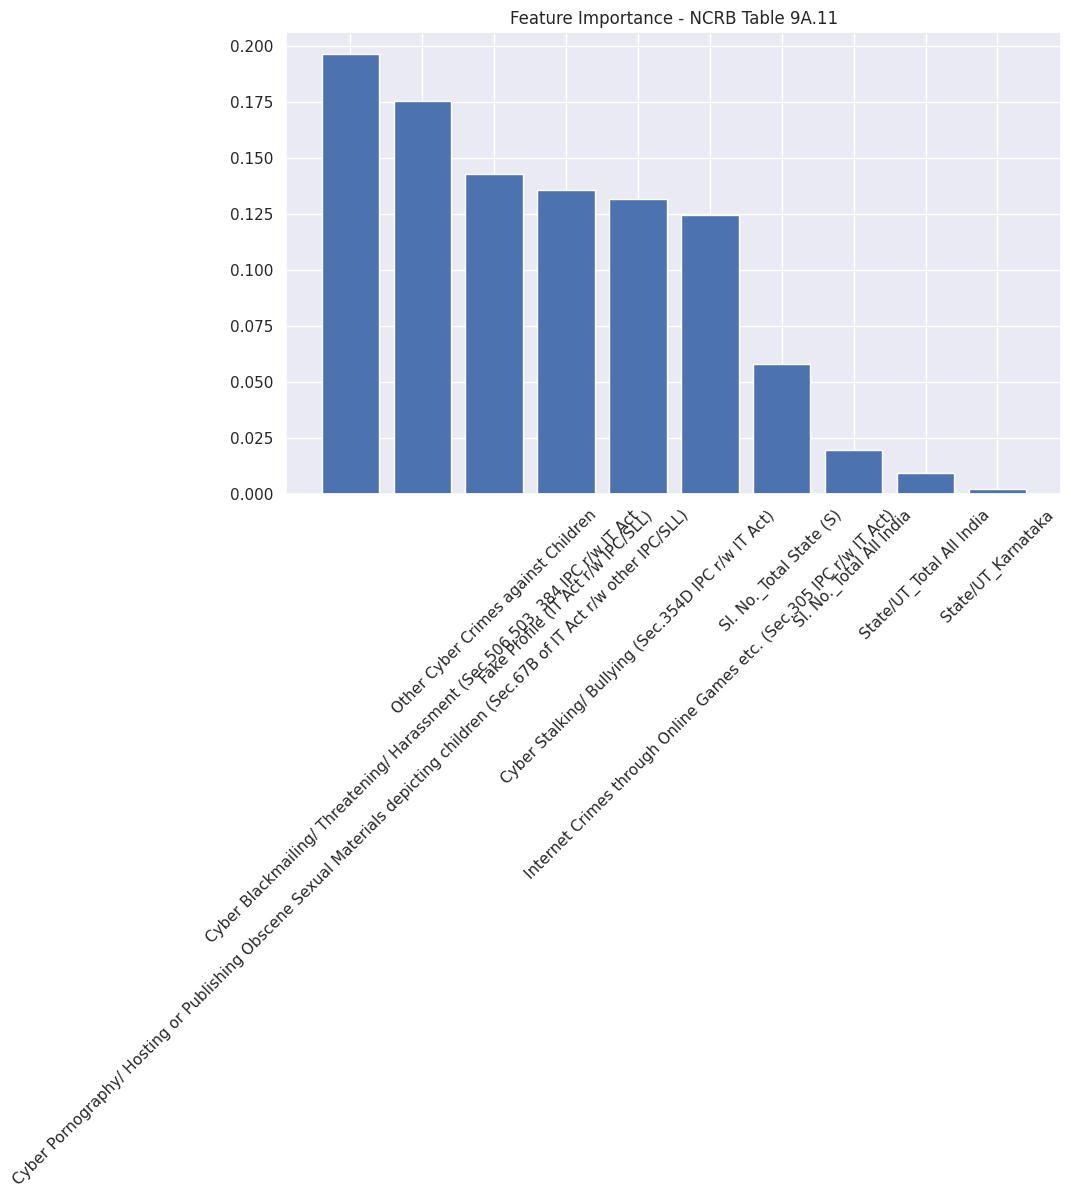

In [7]:
# Cell 6: Enhanced Tabular Analysis with Indian Context
def enhanced_tabular_analysis(df, name):
    """Enhanced analysis with Indian crime context"""
    print(f"\n=== ENHANCED ANALYSIS: {name} ===")

    # Auto-detect target
    target_col, task = pick_tabular_target(df)
    if not target_col:
        print("Could not auto-detect target column")
        return

    print(f"Target: {target_col}, Task: {task}")

    # Prepare data
    X = df.drop(columns=[target_col])
    y = df[target_col]

    # Identify feature types
    numeric_features = X.select_dtypes(include=np.number).columns.tolist()
    categorical_features = X.select_dtypes(include=['object']).columns.tolist()

    print(f"Numeric features: {numeric_features}")
    print(f"Categorical features: {categorical_features}")

    # Create preprocessing pipeline
    numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])

    # Choose model based on task
    if task == 'classification':
        model = RandomForestClassifier(n_estimators=100, random_state=42)
    else:
        model = RandomForestRegressor(n_estimators=100, random_state=42)

    # Create and evaluate pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    # Evaluate
    if task == 'classification':
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))

        # Plot confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot()
        plt.title(f'Confusion Matrix - {name}')
        plt.show()
    else:
        print("\nRegression Metrics:")
        print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f}")
        print(f"R²: {r2_score(y_test, y_pred):.2f}")

        # Plot predictions vs actual
        plt.figure(figsize=(8, 6))
        plt.scatter(y_test, y_pred, alpha=0.5)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.title(f'Actual vs Predicted - {name}')
        plt.show()

    # Feature importance for tree-based models
    if hasattr(model, 'feature_importances_'):
        try:
            # Get feature names after one-hot encoding
            feature_names = numeric_features.copy()
            if categorical_features:
                oh = preprocessor.named_transformers_['cat'].named_steps['onehot']
                cat_feature_names = oh.get_feature_names_out(categorical_features)
                feature_names.extend(cat_feature_names)

            # Plot feature importance
            importances = model.feature_importances_
            indices = np.argsort(importances)[::-1]

            plt.figure(figsize=(10, 6))
            plt.title(f"Feature Importance - {name}")
            plt.bar(range(min(10, len(indices))), importances[indices[:10]])
            plt.xticks(range(min(10, len(indices))), [feature_names[i] for i in indices[:10]], rotation=45)
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"Could not plot feature importance: {e}")

    return pipeline

# Run enhanced analysis on both crime datasets
pipeline_a = enhanced_tabular_analysis(df_ncrb_A, "NCRB Juvenile Data")
pipeline_b = enhanced_tabular_analysis(df_ncrb_B, "NCRB Table 9A.11")


=== COMPREHENSIVE TEXT ANALYSIS ===
Preprocessing text...
Generating word cloud...


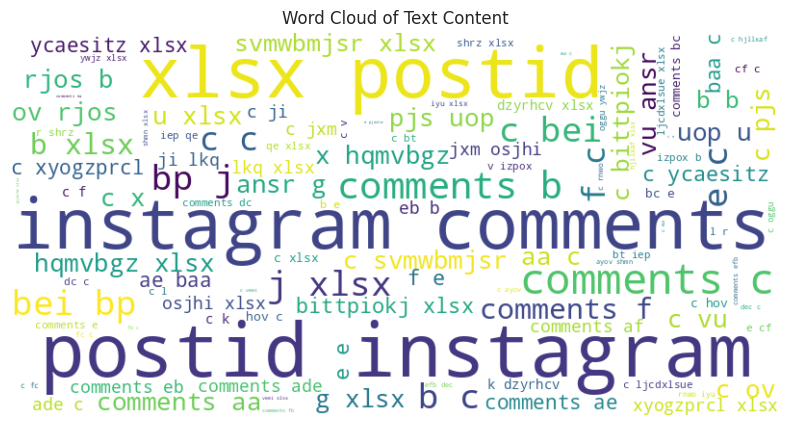

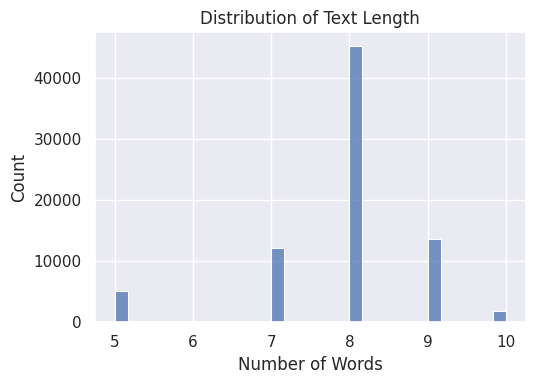

Performing TF-IDF analysis...


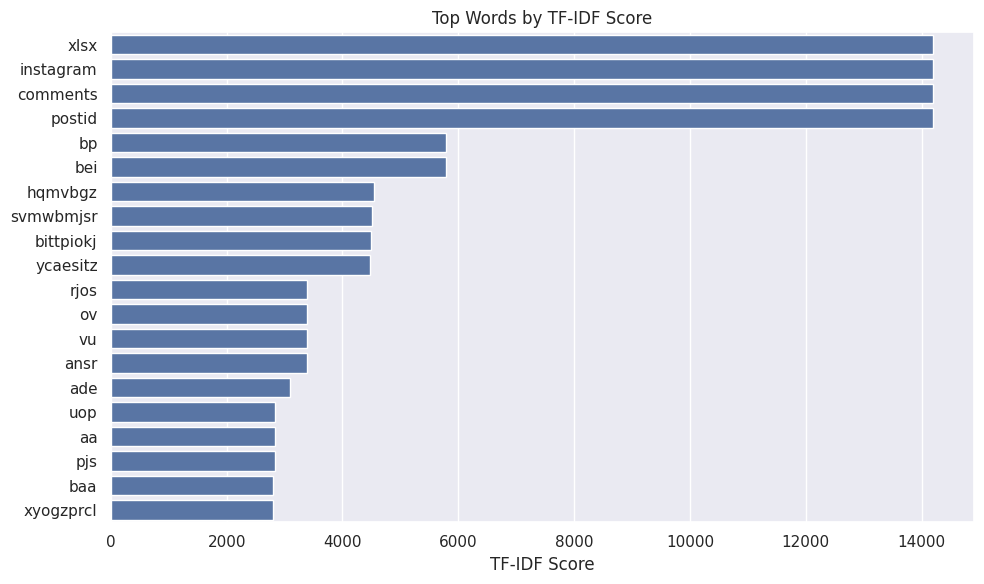

In [8]:
# Cell 7: Comprehensive Text Analysis with Visualizations
def comprehensive_text_analysis(df, text_column, label_column=None):
    """Perform comprehensive text analysis with visualizations"""
    print(f"\n=== COMPREHENSIVE TEXT ANALYSIS ===")

    # Text preprocessing
    print("Preprocessing text...")
    df_clean = df.copy()
    df_clean['cleaned_text'] = df_clean[text_column].apply(nlp_analyzer.clean_text)

    # Word cloud
    print("Generating word cloud...")
    all_text = ' '.join(df_clean['cleaned_text'].dropna().tolist())

    if all_text.strip():
        wordcloud = WordCloud(
            width=800,
            height=400,
            background_color='white',
            stopwords=nlp_analyzer.stop_words
        ).generate(all_text)

        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title('Word Cloud of Text Content')
        plt.show()
    else:
        print("Not enough text for word cloud")

    # Text length analysis
    df_clean['text_length'] = df_clean['cleaned_text'].str.split().str.len()

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    sns.histplot(df_clean['text_length'].dropna(), bins=30)
    plt.title('Distribution of Text Length')
    plt.xlabel('Number of Words')

    if label_column and label_column in df_clean.columns:
        plt.subplot(1, 2, 2)
        sns.boxplot(data=df_clean, x=label_column, y='text_length')
        plt.title('Text Length by Label')
        plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

    # TF-IDF analysis
    print("Performing TF-IDF analysis...")
    tfidf = TfidfVectorizer(max_features=1000, stop_words=list(nlp_analyzer.stop_words))
    tfidf_matrix = tfidf.fit_transform(df_clean['cleaned_text'].dropna())

    # Get top words
    feature_names = tfidf.get_feature_names_out()
    tfidf_scores = tfidf_matrix.sum(axis=0).A1
    top_indices = tfidf_scores.argsort()[-20:][::-1]
    top_words = [feature_names[i] for i in top_indices]
    top_scores = [tfidf_scores[i] for i in top_indices]

    plt.figure(figsize=(10, 6))
    sns.barplot(x=top_scores, y=top_words)
    plt.title('Top Words by TF-IDF Score')
    plt.xlabel('TF-IDF Score')
    plt.tight_layout()
    plt.show()

    return df_clean

# Run text analysis on hate speech data
if text_col:
    df_hate_clean = comprehensive_text_analysis(df_hate, text_col, label_col if 'label_col' in locals() else None)


=== INDIAN CRIME PATTERN ANALYSIS ===
Using columns - State: statename, Year: None, Crime: juv_crime_2018


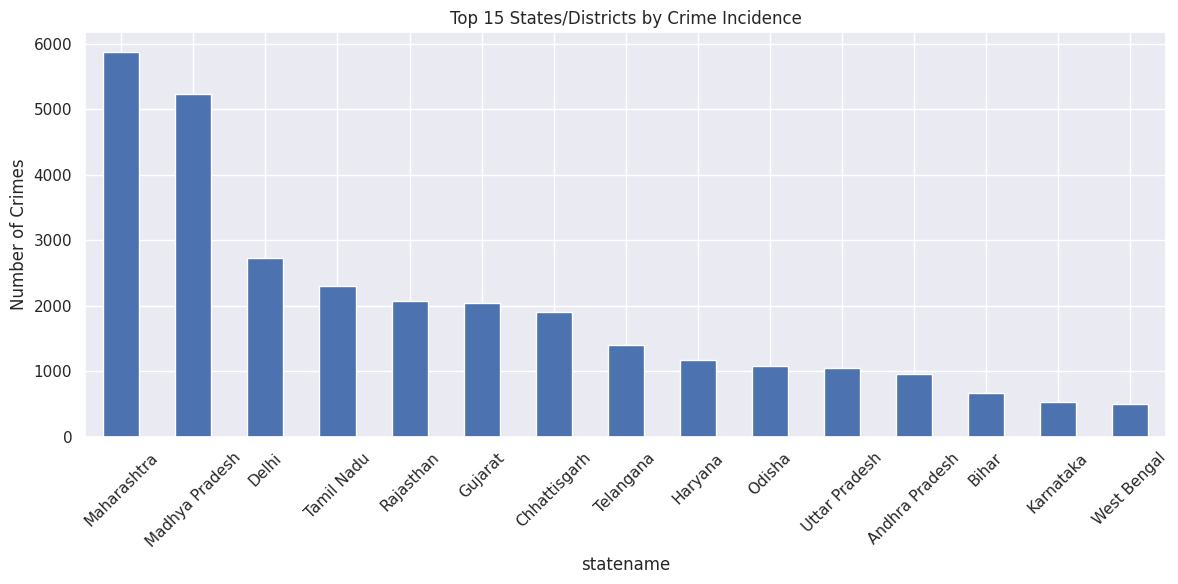


=== INDIAN CRIME PATTERN ANALYSIS ===
Using columns - State: State/UT, Year: None, Crime: Internet Crimes through Online Games etc. (Sec.305 IPC r/w IT Act)


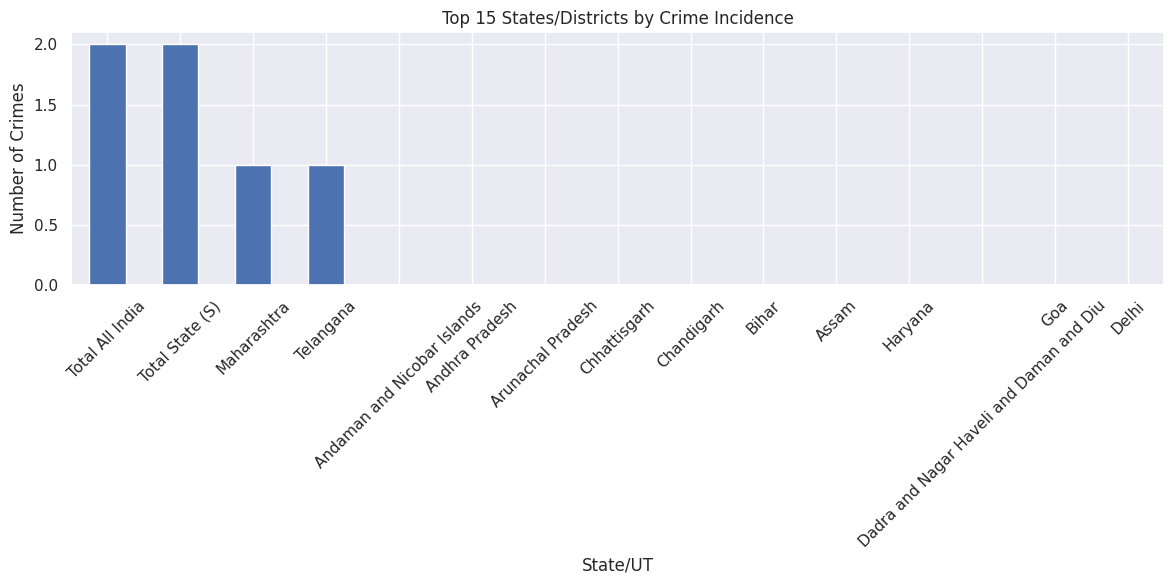

In [9]:
# Cell 8: Indian Crime Pattern Analysis
def analyze_indian_crime_patterns(df, state_col=None, year_col=None, crime_col=None):
    """Analyze Indian crime patterns with a focus on regional and temporal trends"""
    print("\n=== INDIAN CRIME PATTERN ANALYSIS ===")

    # Auto-detect columns if not provided
    if state_col is None:
        state_candidates = [col for col in df.columns if any(word in col.lower() for word in ['state', 'district', 'region'])]
        state_col = state_candidates[0] if state_candidates else None

    if year_col is None:
        year_candidates = [col for col in df.columns if 'year' in col.lower()]
        year_col = year_candidates[0] if year_candidates else None

    if crime_col is None:
        crime_candidates = [col for col in df.columns if any(word in col.lower() for word in ['crime', 'case', 'offense'])]
        crime_col = crime_candidates[0] if crime_candidates else None

    print(f"Using columns - State: {state_col}, Year: {year_col}, Crime: {crime_col}")

    # State-wise analysis
    if state_col and crime_col:
        state_crimes = df.groupby(state_col)[crime_col].sum().sort_values(ascending=False)

        plt.figure(figsize=(12, 6))
        state_crimes.head(15).plot(kind='bar')
        plt.title('Top 15 States/Districts by Crime Incidence')
        plt.xticks(rotation=45)
        plt.ylabel('Number of Crimes')
        plt.tight_layout()
        plt.show()

    # Yearly trends
    if year_col and crime_col:
        yearly_trend = df.groupby(year_col)[crime_col].sum()

        plt.figure(figsize=(10, 5))
        yearly_trend.plot(marker='o')
        plt.title('Crime Trends Over Years')
        plt.xlabel('Year')
        plt.ylabel('Number of Crimes')
        plt.grid(True)
        plt.show()

    # Crime type analysis (if available)
    crime_type_col = None
    for col in df.columns:
        if any(word in col.lower() for word in ['type', 'category', 'kind']):
            crime_type_col = col
            break

    if crime_type_col and crime_col:
        crime_types = df.groupby(crime_type_col)[crime_col].sum().sort_values(ascending=False)

        plt.figure(figsize=(10, 6))
        crime_types.head(10).plot(kind='bar')
        plt.title('Top 10 Crime Types')
        plt.xticks(rotation=45)
        plt.ylabel('Number of Crimes')
        plt.tight_layout()
        plt.show()

# Run Indian crime pattern analysis
analyze_indian_crime_patterns(df_ncrb_A)
analyze_indian_crime_patterns(df_ncrb_B)

In [10]:
# Cell 9: Save Results and Generate Report
def generate_final_report():
    """Generate a comprehensive report of the analysis"""
    report = {
        "project": "Indian Crime Analysis with NLP",
        "datasets": {
            "ncrb_juvenile": {
                "shape": df_ncrb_A.shape,
                "columns": list(df_ncrb_A.columns)
            },
            "ncrb_table_9A11": {
                "shape": df_ncrb_B.shape,
                "columns": list(df_ncrb_B.columns)
            },
            "hate_speech": {
                "shape": df_hate.shape,
                "columns": list(df_hate.columns)
            }
        },
        "models_used": [
            "RandomForest (tabular data)",
            "TF-IDF + Classifiers (text data)",
            "HuggingFace Transformers (sentiment, hate speech, emotion)"
        ],
        "analysis_performed": [
            "Exploratory Data Analysis",
            "Tabular Model Training",
            "Text Preprocessing",
            "Sentiment Analysis",
            "Hate Speech Detection",
            "Emotion Classification",
            "Named Entity Recognition",
            "Indian Crime Pattern Analysis"
        ]
    }

    # Save report
    with open(os.path.join(ARTIFACT_DIR, "analysis_report.json"), "w") as f:
        json.dump(report, f, indent=2)

    print("Final report generated and saved!")

    return report

# Generate and display report
final_report = generate_final_report()
print("\n=== FINAL REPORT ===")
print(json.dumps(final_report, indent=2))

Final report generated and saved!

=== FINAL REPORT ===
{
  "project": "Indian Crime Analysis with NLP",
  "datasets": {
    "ncrb_juvenile": {
      "shape": [
        36,
        14
      ],
      "columns": [
        "objectid",
        "statename",
        "id",
        "lgd_statecode",
        "censuscode2011",
        "juv_crime_2018",
        "juv_crime_2019",
        "juv_crime_2020",
        "juv_crime_2021",
        "juv_crime_2022",
        "child_pop2011",
        "juv_crimerate_2022",
        "st_areashape",
        "st_lengthshape"
      ]
    },
    "ncrb_table_9A11": {
      "shape": [
        39,
        9
      ],
      "columns": [
        "Sl. No.",
        "State/UT",
        "Cyber Blackmailing/ Threatening/ Harassment (Sec.506,503, 384 IPC r/w IT Act",
        "Fake Profile (IT Act r/w IPC/SLL)",
        "Cyber Pornography/ Hosting or Publishing Obscene Sexual Materials depicting children (Sec.67B of IT Act r/w other IPC/SLL)",
        "Cyber Stalking/ Bullying (